**<h3>Python Script Imports</h3>**

In [24]:
# Python Library imports
import os
import sys
import importlib    
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# Paths
housing_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/datasets/housing.csv"
python_scripts_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/python-scripts"
custom_transformers_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/python-scripts/custom-transformers"
model_dumps_path = r"E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/model_dumps"

# Path initialization so that Python can see where our script lies.
script_dir = os.path.abspath(python_scripts_path) 
custom_transformers_script_dir = os.path.abspath(custom_transformers_path) 
sys.path.append(script_dir)
sys.path.append(custom_transformers_script_dir)
sys.path.append(model_dumps_path)

# Custom Python Script Imports
from sklearn.model_selection import StratifiedShuffleSplit
from test_set_check import test_set_check
from split_train_test_by_id import split_train_test_by_id
from load_housing_data import load_housing_data
from combined_attributes_adder import CombinedAttributesAdder
from data_frame_selector import DataFrameSelector
from display_scores import display_scores
# Loads housing data
housing = load_housing_data(housing_path)

**<h3>Important</h3>** 
- This is the continuation from the existing notebook: **`I. Prepare data for Machine Learning`** 

**<h2>Stage 1 - Prepare the Data</h2>**

**<h3>Step 1 - Prepare the housing data and label data</h3>**

In [2]:
#limits number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) 
#merge "larger than 5" categories into category 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=False) 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

**<h3>Step 2 - Prepare the Pipeline for Numerical data</h3>**
**<h5>Small notes</h5>** 
- **Pipeline**: A series of steps that apply changes on the data.
- **Numerical Data**: In this case (housing data for 1 district), numerical data/attributes are these columns: 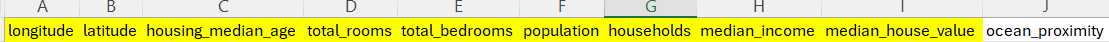
- **`fit()`**: The function that runs the pipeline

**<h5>Script Explanation</h5>** 
- **`SimpleImputer`**: A transformer that fills in empty cells with, in this case, the median value.
- **`CombinedAttributesAdder`**: A transformer that
  + Takes 2 existing attributes in the dataset
  + Combines them into 1.
  + Example: 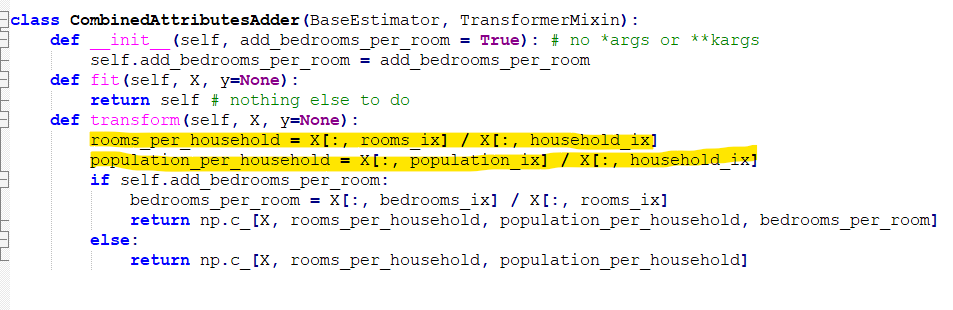
- **`StandardScaler()`**: Applies feature scaling, that is, convert attributes of various ranges to a unified range. Example:
  + Before conversion
    + **`total_rooms`**: values range from 2 to 39320 (large difference)
    + **`housing_median_age`**: values range from 1 to 52 (small difference)
  + After conversion
    + **`total_rooms`**: values range from 0 to 1 
    + **`housing_median_age`**: values range from 0 to 1 (same)

In [3]:
housing_num = housing.drop("ocean_proximity", axis=1) 
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

**<h3>Step 2.1</h3>**
**<h5>Definition</h5>** 
- **`DataFrameSelector`**: A custom transformer that:
  + **Steps:**
    + Takes the attribute by name
    + Convert the DataFrame to NumPy array
  + **Image**: 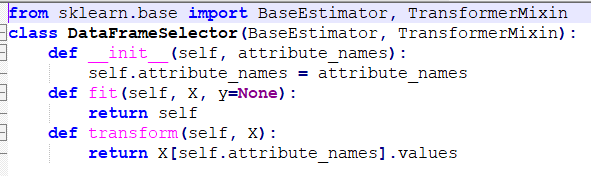
  + **Example**:
    + Here, **`num_attribs`** contains a list of non-string attributes: 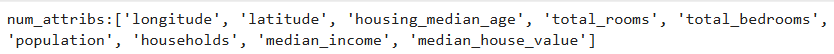
    + For each attribute **`(e.g. housing_median_age)`**, get all values within there: 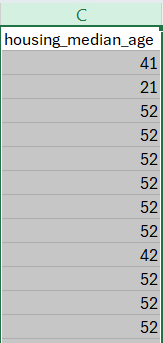

In [4]:
num_attribs = list(housing_num)
print("num_attribs:" + str(num_attribs))
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
('selector', DataFrameSelector(num_attribs)),
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

num_attribs:['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'income_cat']


**<h3>Step 2 - Prepare the Pipeline for Categorical Data</h3>**

**<h5>Definition</h5>**
- Categorical Data: In this case (housing data for 1 district), categorical data is the **`ocean_proximity`** column. 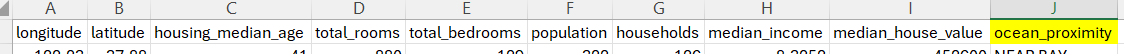


In [5]:
cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)),
('cat_encoder', OneHotEncoder(sparse_output=True)),
])

**<h3>Step 3 - Combine Numeric & Categorical Pipelines</h3>**

In [6]:
full_pipeline = FeatureUnion(transformer_list=[
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 17)

**<h2>Stage 2 - Select and Train a Model</h2>**

**<h3>Model: Linear Regression</h3>**

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [8]:
some_data = housing.iloc[:5] # selects the first 5 rows of housing training data
some_labels = housing_labels.iloc[:5] # selects the first 5 rows of housing answer  data
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210470.98864129 661390.82122241 212482.55168425  56554.82437529
 184931.83007887]
Labels: [286600.0, 500001.0, 196900.0, 46300.0, 254500.0]


**<h3>Model: Mean squared error</h3>**

In [14]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66650.88836453 66113.66276385 67340.90775948 74448.79400907
 71411.93310781 69777.57851118 65363.3392723  67637.20211681
 69674.77363437 67373.4007457 ]
Mean: 68579.24802850952
Standard deviation: 2629.193843854298


**<h3>Problem</h3>**
- **`median_housing_values`** are between **`$120,000`** and **`$265,000`**
- But, our model predicts about **`$68.000`** (way lower than the range). This is called **underfitting** (the ML model hasn't learnt enough from the data)

**<h3>Root cause</h3>**
- Not enough features (columns). In this case, the yellow columns are the features ML model used to learn: 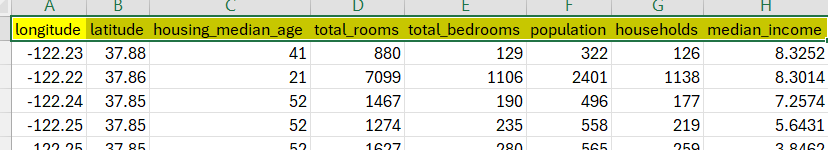, 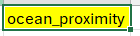
- Model is not powerful enough

**<h3>Solutions</h3>**
- Feed the model with more better features
- Use a more complex model (use this one)

**<h3>Model: DecisionTreeRegressor</h3>**

In [10]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [11]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

**<h3>Problem</h3>**
- **`tree_rmse`** returns 0 (no errors.)
- This is super weird, and chances are it has overfit the data.

- Overfit: memorizes the entire training set, instead of learning the pattern from it.

**<h3>Solution: Cross-validation</h3>**
**<h5>Idea</h5>**
- Given 2 existing sets: **training** set (**`A`**) and **test** set (**`B`**)
- Take training set (**`A`**) and split it to 2 parts: **smaller training** set (**`A1`**) and **validation** set (**`A2`**)
- Train the model with **`A1`**, and check (validate) against **`A2`**.

**<h5>K-fold cross-validation</h5>**
**Idea:** 
- Split training set into K subsets (folds) (e.g. 10)
- For each fold, pick it and train it. After that, check the result against the 9 remaining folds.
- The result is an array containing 10 evaluation scores.


In [13]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [66987.33308881 66900.88900876 68370.42007539 69959.84304273
 71263.57105639 75466.11794309 68349.21285426 74035.58418862
 74542.82350408 71231.50804939]
Mean: 70710.73028115116
Standard deviation: 2982.052505095676


**<h3>Model: RandomForestRegressor</h3>**

**<h5>How RandomForestRegressor works</h5>**
- **Split training set** into multiple subsets (e.g. folds)
- **Train** many **Decision Trees on random subsets** (picked from multiple subsets)
- After many Decision Trees are trained, **combine them to calculate the average prediction**
This is also called Ensemble Learning (build a model on top of many other models)
 

In [18]:
forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
display_scores(forest_rmse)

Scores: 18792.832155944678
Mean: 18792.832155944678
Standard deviation: 0.0


**<h3>Conclusion</h3>**

- Random Forest is also okay, but it still overfits (score on training set is lower than validation sets)
- Solutions: Simplify the model/constrain/add more training data
- However, besides deep-diving into Random Forest, we should:
  + Try out other models
  + Don't spend too much time tweaking the models.
Goal: select the most promising models for training.

**<h3>Save the Progress</h3>**
- Use the **`joblib.dump`** function to save the training progress of a ML model.

In [25]:
#Example 1: Dump (save) the training progress of linear regression model
model_dump_path_with_name = model_dumps_path + 'linear_regression_dump.pkl'
joblib.dump(lin_reg, model_dump_path_with_name)

['E:/Future Plans/Post-Graduation-Projects/Hands-on Machine Learning/first-project/model_dumpslinear_regression_dump.pkl']